# Load basic library

In [1]:
# Import standard data manipulation and visualization libraries
import numpy as np
import pandas as pd
import seaborn as sns
import optuna
from scipy.stats import skew
import warnings
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# Import gradient boosting libraries
import lightgbm as lgb
import xgboost as xgb
import catboost as catb

In [3]:
# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)

/tmp/ipykernel_13/3251733192.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Set random seed to have reproducibile result

In [4]:
# For reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Now we can load our data.
And we can check some basic information about our data

In [5]:
# Load datasets
train = pd.read_csv('/kaggle/input/playground-series-s5e9/train.csv')  
test = pd.read_csv('/kaggle/input/playground-series-s5e9/test.csv')    
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e9/sample_submission.csv')  

In [6]:
# Display information about the datasets
print("Train data shape")
print(train.shape)
print("Test data shape")
print(test.shape)
print("sample_submission data shape")
print(sample_submission.shape)

Train data shape
(524164, 11)
Test data shape
(174722, 10)
sample_submission data shape
(174722, 2)


In [7]:
# Check the submission format
print(sample_submission.head())

       id  BeatsPerMinute
0  524164         119.035
1  524165         119.035
2  524166         119.035
3  524167         119.035
4  524168         119.035


In [8]:
# Check for missing values
print("train data null data sum")
print(train.isnull().sum())
print("test data null data sum")
print(test.isnull().sum())

train data null data sum
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64
test data null data sum
id                           0
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
dtype: int64


In [9]:
# check head data
print(train.head())
#print(test.head())

   id  RhythmScore  AudioLoudness  VocalContent  AcousticQuality  \
0   0     0.603610      -7.636942      0.023500         0.000005   
1   1     0.639451     -16.267598      0.071520         0.444929   
2   2     0.514538     -15.953575      0.110715         0.173699   
3   3     0.734463      -1.357000      0.052965         0.001651   
4   4     0.532968     -13.056437      0.023500         0.068687   

   InstrumentalScore  LivePerformanceLikelihood  MoodScore  TrackDurationMs  \
0           0.000001                   0.051385   0.409866      290715.6450   
1           0.349414                   0.170522   0.651010      164519.5174   
2           0.453814                   0.029576   0.423865      174495.5667   
3           0.159717                   0.086366   0.278745      225567.4651   
4           0.000001                   0.331345   0.477769      213960.6789   

     Energy  BeatsPerMinute  
0  0.826267       147.53020  
1  0.145400       136.15963  
2  0.624667        55.3198

# Set our data proprocess function

In [10]:
def new_features(df):
    # Handle missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Polynomial features
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_features = poly.fit_transform(df[['RhythmScore', 'AudioLoudness', 'Energy']])
    poly_cols = [f'poly_{i}' for i in range(poly_features.shape[1])]
    df[poly_cols] = poly_features
    
    # Log transformation for skewed features
    for col in ['TrackDurationMs', 'AudioLoudness', 'VocalContent']:
        if col in df.columns and skew(df[col].dropna()) > 0.5:
            if df[col].min() < 0:
                shift = abs(df[col].min()) + 1
                df[f'log_{col}'] = np.log1p(df[col] + shift)
            else:
                df[f'log_{col}'] = np.log1p(df[col].clip(lower=0))
    
    # Binning features
    df['Duration_Bin'] = pd.qcut(df['TrackDurationMs'], q=10, labels=False, duplicates='drop')
    df['Energy_Bin'] = pd.qcut(df['Energy'], q=5, labels=False, duplicates='drop')
    
    return df

In [11]:
train_data = new_features(train)
test_data = new_features(test)

In [12]:
train_x = train_data.drop(['BeatsPerMinute' , 'id'] , axis=1)
train_y = train_data['BeatsPerMinute']

test_x = test_data.drop('id' , axis=1)

# Split training data into train and valid

In [13]:
X_train_final, X_valid, y_train_fianl, y_valid = train_test_split(train_x, train_y, train_size=0.8, test_size=0.2,random_state=0)

# Use pipline get a better model performance

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor

In [15]:
def get_score(n_estimators):
    """Return the average MAE over 3 CV folds of XGBRegressor model.
    
    Keyword argument:
    n_estimators -- the number of trees in the forest
    """
    my_pipeline = Pipeline(steps=[
        ('preprocessor', SimpleImputer()),
        ('model', XGBRegressor(n_estimators=n_estimators, learning_rate=0.05) )
    ])
    scores = -1 * cross_val_score(my_pipeline, X_train_final, y_train_fianl,
                              cv=3,
                              scoring='neg_mean_absolute_error')
    return scores.mean()

In [16]:
results = {}
for i in range(1,10):
    results[10*i] = get_score(10*i)

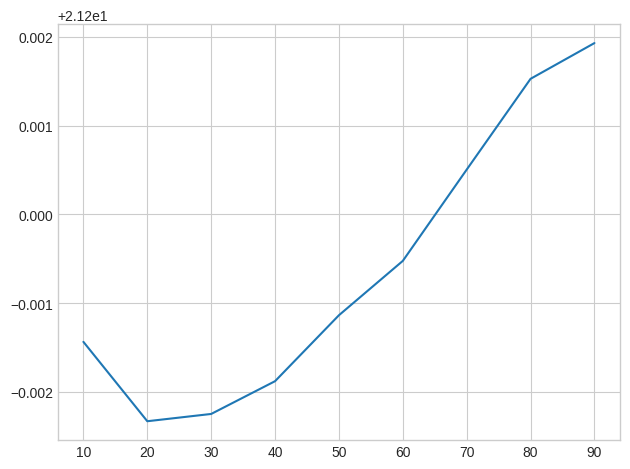

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

With this result we can get that parameter "n_estimators" perform best at 20

# Run model with training data

In [18]:
# Define the model
my_model_1 = XGBRegressor(n_estimators=20, learning_rate=0.05) 

# Fit the model
my_model_1.fit(X_train_final, y_train_fianl)

# Get predictions
predictions_1 = my_model_1.predict(X_valid)

# Calculate MAE
mae_1 =  mean_absolute_error(predictions_1, y_valid)

# Uncomment to print MAE
print("Mean Absolute Error:" , mae_1)


Mean Absolute Error: 21.184346184696103


# Predict test data to generate final prediction

In [19]:
final_preds = np.round(my_model_1.predict(test_x),3)

In [20]:
print(final_preds)

[119.196 117.966 118.963 ... 118.946 118.853 119.419]


# Preparing the Submission

In [21]:
submission = pd.DataFrame({'id': test_data['id'], 'BeatsPerMinute': final_preds})
submission.to_csv('submission.csv', index=False)
display(submission.head())

,id,BeatsPerMinute
0,524164,119.195999
1,524165,117.966003
2,524166,118.962997
3,524167,119.000000
4,524168,119.361000
